In [2]:
import pandas as pd
import os
import seaborn as sns
from config import *
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix

In [3]:
result_dir='algorithm_classification_results'
seeds=[200,400,600,800,1000]
visualizations_dir='algorithm_classification_visualizations'
train_on_seed=True
difference=False

seed_mapping={index:seed for index,seed in enumerate(seeds)}

In [4]:
os.makedirs(visualizations_dir,exist_ok=True)

In [5]:
def get_global_file_name(dimension,algorithms, iteration_start,iteration_end, train_on_seed,seed, difference,stat=None, normalize_y=False):
    file_name=f'dim_{dimension}_{algorithms}_it_{iteration_start}-{iteration_end}_instance_count_100_{"train" if train_on_seed else "test"}_on_seed_{seed}{"_differenced" if difference else ""}'
    if stat is None:
        return os.path.join(result_dir + f'_normalize_{normalize_y}' ,file_name)
    else:
        return os.path.join(result_dir+ f'_normalize_{normalize_y}',f'stat_{stat}_' + file_name)


def get_visualization_output_name_without_seed(dimension,algorithms, iteration_start,iteration_end, train_on_seed, difference):
    return os.path.join(visualizations_dir,f'dim_{dimension}_{algorithms}_it_{iteration_start}-{iteration_end}_instance_count_100_{"train" if train_on_seed else "test"}_on_seed{"_differenced" if difference else ""}')

In [6]:
def get_seed_accuracies_df(dimension,algorithm, iteration_start, iteration_end, train_on_seed, difference, seeds, stat=None, normalize_y=False):
    seed_accuracies=[]
    test_df_all=pd.DataFrame()
    for train_seed in seeds:
        test_df=pd.DataFrame()
        for fold in range(0,10):

            global_file_name=get_global_file_name(dimension,algorithm, iteration_start,iteration_end, train_on_seed,train_seed, difference, stat,normalize_y)
            file_location=global_file_name+f'_fold_{fold}_test_preds.csv'

            if not os.path.isfile(file_location):
                print('Not found', file_location)
                continue
            #print(file_location)
            test_df_fold=pd.read_csv(file_location, index_col=[0], compression='zip').rename(columns={'seed':'test_seed'}) 
            test_df_fold['fold']=fold
            test_df_fold['train_seed']=train_seed
            test_df=pd.concat([test_df,test_df_fold])
            test_df_all=pd.concat([test_df_all,test_df_fold])

        if test_df_all.shape[0]==0:
            return None,None

        for test_seed in seeds:
            for fold in range(0,10):
                if test_df.shape[0]==0:
                    continue
                seed_preds_df=test_df.query('test_seed==@test_seed and fold==@fold')
                seed_accuracies+=[(accuracy_score(seed_preds_df['y'], seed_preds_df['preds']), train_seed, test_seed, fold)]


    if len(seed_accuracies)>0:
        seed_accuracy_df=pd.DataFrame(seed_accuracies)
        seed_accuracy_df.columns=['accuracy','train_seed','test_seed','fold']
        return seed_accuracy_df, test_df_all
    return None,None

In [7]:
def plot_accuracy_per_statistic(all_stats,all_dimensions):
    sns.set(font_scale=1)
    results_per_iteration=[]
    all_algorithms='DE_PSO_ES'
    all_accuracies=pd.DataFrame()
    for stat in all_stats:

        for normalize_y in [False,True]:
            for dimension in all_dimensions: #
                for train_on_seed in [True]:
                    for difference in [False,True]:
                        for end_iteration in [0,2,4,9,19,29]:
                            if end_iteration==0 and difference_1:
                                continue
                            seed_accuracy_df,_ = get_seed_accuracies_df(dimension,all_algorithms, 0, end_iteration, train_on_seed, difference, seeds,stat, normalize_y=normalize_y)
                            seed_accuracy_df['feature calculation budget']=end_iteration+1
                            seed_accuracy_df['dimension']=dimension
                            seed_accuracy_df['statistic']=stat
                            seed_accuracy_df['normalize_y']=normalize_y
                            seed_accuracy_df['difference']=difference
                            all_accuracies=pd.concat([all_accuracies,seed_accuracy_df])


    all_accuracies=all_accuracies.query("train_seed!=test_seed")
    fig, axes = plt.subplots(len(all_dimensions),4, figsize=(12,len(all_dimensions)*3), sharex=True, sharey=True)

    for dimension_index,dimension in enumerate(all_dimensions):
        for difference_index, difference in enumerate([False,True]):
            for normalize_index, normalize_y in enumerate([False,True]):

                accuracies=all_accuracies.query('dimension==@dimension and normalize_y==@normalize_y and difference==@difference')
                print(all_accuracies.shape)
                print(accuracies.shape)
                accuracies=accuracies[accuracies['feature calculation budget']!=1]
                accuracies=accuracies.groupby(['dimension','statistic','feature calculation budget','difference', 'normalize_y']).median()
                print(accuracies['accuracy'])
                ax=axes[dimension_index,difference_index*2 + normalize_index] if type(axes) is np.ndarray else axes
                ax.set_title(f'Dimension: {dimension} \n Difference: {difference} \n Scale y: {normalize_y}')
                sns.lineplot(x="feature calculation budget", y="accuracy",
                         hue="statistic", ax=ax,style="statistic",markers=True,dashes=False,
                         data=accuracies,palette=[light_blue,dark_cyan,lime, grey], hue_order=all_stats)

                if dimension_index==0 and normalize_index==1 and difference_index==1:
                    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
                else: 
                    ax.get_legend().remove()
    plt.tight_layout()
    plt.savefig(os.path.join(visualizations_dir,f'{"-".join(all_stats)}_accuracies_per_statistic_per_dimension_{"train" if train_on_seed else "test"}_on_seed.pdf'))
    plt.show()
    return all_accuracies


In [225]:
x_y_accuracies.groupby(['dimension','statistic','feature calculation budget','difference', 'normalize_y']).median().query('difference==False and statistic=="x"')

accuracy  \
dimension statistic feature calculation budget difference normalize_y             
3         x         3                          False      False        0.492778   
                                                          True         0.488333   
                    5                          False      False        0.577222   
                                                          True         0.577500   
                    10                         False      False        0.688333   
                                                          True         0.697222   
                    20                         False      False        0.745278   
                                                          True         0.746667   
                    30                         False      False        0.805278   
                                                          True         0.810000   
20        x         3                          False      False        0.992778   
                                                          True         1.000000   
                    5                          False      False        0.989444   
                                                          True         1.000000   
                    10                         False      False        0.993333   
                                                          True         0.998889   
                    20                         False      False        0.998333   
                                                          True         1.000000   
                    30                         False      False        1.000000   
                                                          True         1.000000   

                                                                       train_seed  \
dimension statistic feature calculation budget difference normalize_y               
3         x         3                          False      False             600.0   
                                                          True              600.0   
                    5                          False      False             600.0   
                                                          True              600.0   
                    10                         False      False             600.0   
                                                          True              600.0   
                    20                         False      False             600.0   
                                                          True              600.0   
                    30                         False      False             600.0   
                                                          True              600.0   
20        x         3                          False      False             600.0   
                                                          True              600.0   
                    5                          False      False             600.0   
                                                          True              600.0   
                    10                         False      False             600.0   
                                                          True              600.0   
                    20                         False      False             600.0   
                                                          True              600.0   
                    30                         False      False             600.0   
                                                          True              600.0   

                                                                       test_seed  \
dimension statistic feature calculation budget difference normalize_y              
3         x         3                          False      False            600.0   
                                                          True             600.0   
                    5                

(16000, 9)
(2000, 9)
dimension  statistic  feature calculation budget  difference  normalize_y
3          x          3                           False       False          0.492778
                      5                           False       False          0.577222
                      10                          False       False          0.688333
                      20                          False       False          0.745278
                      30                          False       False          0.805278
           y          3                           False       False          0.745000
                      5                           False       False          0.783333
                      10                          False       False          0.735278
                      20                          False       False          0.653333
                      30                          False       False          0.699167
Name: accuracy, dtype: float64
(16000, 9)
(20

/tmp/ipykernel_4458/93436995.py:39: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.lineplot(x="feature calculation budget", y="accuracy",
/tmp/ipykernel_4458/93436995.py:39: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.lineplot(x="feature calculation budget", y="accuracy",
/tmp/ipykernel_4458/93436995.py:39: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.lineplot(x="feature calculation budget", y="accuracy",


(16000, 9)
(2000, 9)
dimension  statistic  feature calculation budget  difference  normalize_y
3          x          3                           True        True           0.840556
                      5                           True        True           0.878333
                      10                          True        True           0.901667
                      20                          True        True           0.930000
                      30                          True        True           0.938333
           y          3                           True        True           0.890556
                      5                           True        True           0.906667
                      10                          True        True           0.931667
                      20                          True        True           0.933333
                      30                          True        True           0.928333
Name: accuracy, dtype: float64
(16000, 9)
(20

/tmp/ipykernel_4458/93436995.py:39: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.lineplot(x="feature calculation budget", y="accuracy",
/tmp/ipykernel_4458/93436995.py:39: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.lineplot(x="feature calculation budget", y="accuracy",
/tmp/ipykernel_4458/93436995.py:39: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.lineplot(x="feature calculation budget", y="accuracy",


(16000, 9)
(2000, 9)
dimension  statistic  feature calculation budget  difference  normalize_y
10         x          3                           True        False          1.000000
                      5                           True        False          1.000000
                      10                          True        False          1.000000
                      20                          True        False          1.000000
                      30                          True        False          1.000000
           y          3                           True        False          0.786111
                      5                           True        False          0.855556
                      10                          True        False          0.893333
                      20                          True        False          0.905556
                      30                          True        False          0.878333
Name: accuracy, dtype: float64
(16000, 9)
(20

/tmp/ipykernel_4458/93436995.py:39: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.lineplot(x="feature calculation budget", y="accuracy",
/tmp/ipykernel_4458/93436995.py:39: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.lineplot(x="feature calculation budget", y="accuracy",


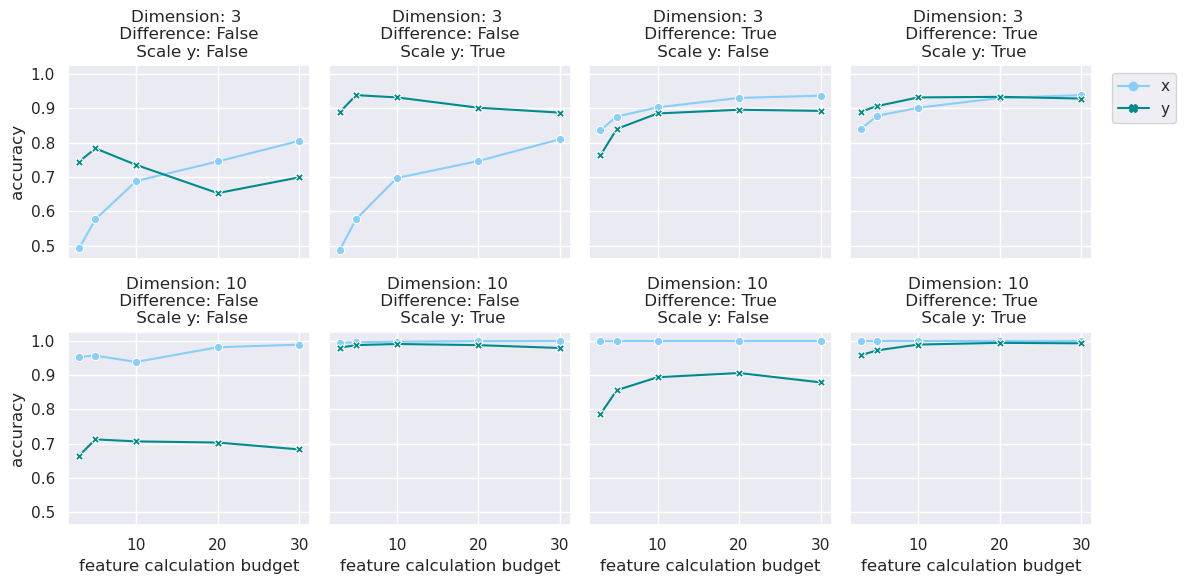

In [233]:
x_y_accuracies=plot_accuracy_per_statistic(['x','y'],[3,10])

(32000, 9)
(4000, 9)
dimension  statistic  feature calculation budget  difference  normalize_y
3          max        3                           False       False          0.503889
                      5                           False       False          0.568056
                      10                          False       False          0.610000
                      20                          False       False          0.648611
                      30                          False       False          0.680833
           mean       3                           False       False          0.654167
                      5                           False       False          0.718333
                      10                          False       False          0.723333
                      20                          False       False          0.725000
                      30                          False       False          0.721667
           min        3                      

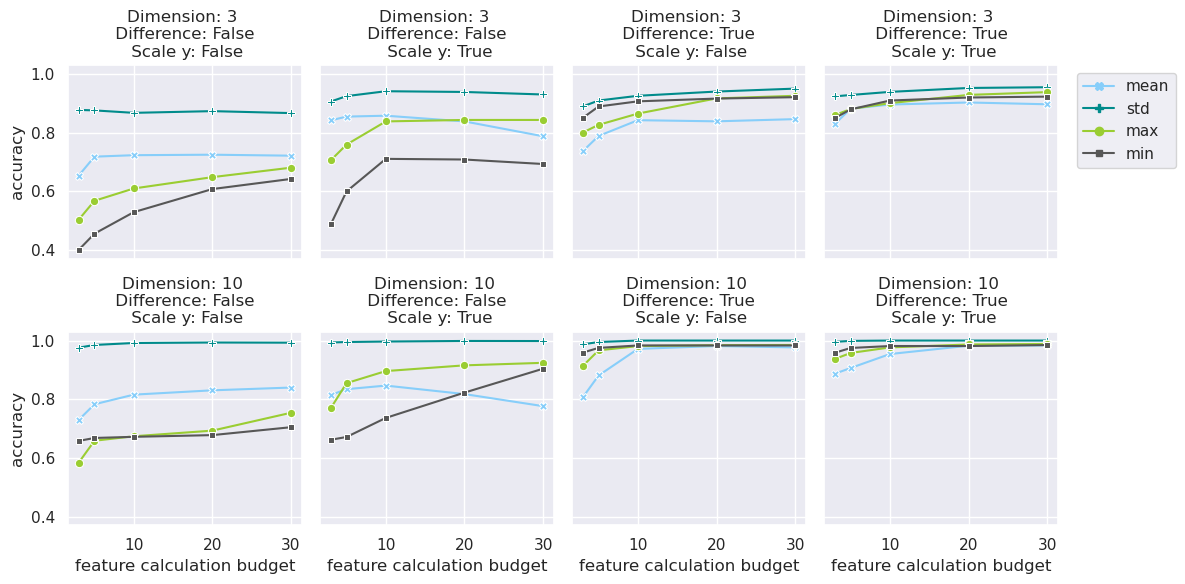

In [234]:
stat_accuracies=plot_accuracy_per_statistic(['mean','std','max','min'],[3,10])

In [223]:
stat_accuracies.groupby(['dimension','statistic','feature calculation budget','difference', 'normalize_y']).median().query('dimension==20 and statistic=="min" and difference==True')

accuracy  \
dimension statistic feature calculation budget difference normalize_y             
20        min       3                          True       False        0.996667   
                                                          True         0.996667   
                    5                          True       False        0.998333   
                                                          True         0.998333   
                    10                         True       False        1.000000   
                                                          True         1.000000   
                    20                         True       False        1.000000   
                                                          True         1.000000   
                    30                         True       False        1.000000   
                                                          True         1.000000   

                                                                       train_seed  \
dimension statistic feature calculation budget difference normalize_y               
20        min       3                          True       False             600.0   
                                                          True              600.0   
                    5                          True       False             600.0   
                                                          True              600.0   
                    10                         True       False             600.0   
                                                          True              600.0   
                    20                         True       False             600.0   
                                                          True              600.0   
                    30                         True       False             600.0   
                                                          True              600.0   

                                                                       test_seed  \
dimension statistic feature calculation budget difference normalize_y              
20        min       3                          True       False            600.0   
                                                          True             600.0   
                    5                          True       False            600.0   
                                                          True             600.0   
                    10                         True       False            600.0   
                                                          True             600.0   
                    20                         True       False            600.0   
                                                          True             600.0   
                    30                         True       False            600.0   
                                                          True             600.0   

                                                                       fold  
dimension statistic feature calculation budget difference normalize_y        
20        min       3                          True       False         4.5  
                                                          True          4.5  
                    5                          True       False         4.5  
                                                          True          4.5  
                    10                         True       False         4.5  
                                                          True          4.5  
                    20                         True       False         4.5  
                                                          True          4.5  
                    30                         True       False         4.5  
                                                          True          4.5

In [ ]:
fig, axes = plt.subplots(int(len(all_stats)/2),2, figsize=(8,8), sharex=True, sharey=True)
for index, stat in enumerate(all_stats):
    accuracies=all_accuracies.query('stat==@stat')
    ax=axes[int(index/2), index%2] if type(axes) is np.ndarray else axes
    ax.set_title(f'Stat: {stat}')
    sns.violinplot(data=accuracies, x="feature calculation budget (iterations)", y="accuracy", hue='Evaluation on trajectories from training seed', split=True, palette=color_palette[1:3], ax=ax)
    if index != 0:
        ax.get_legend().remove()
plt.tight_layout()

plt.savefig(os.path.join(visualizations_dir,f'accuracies_per_statistic.pdf'))
plt.show()

In [25]:
def accuracy_subplots(all_accuracies, all_groupings, group_name, file_name):
    fig, axes = plt.subplots(int(len(all_groupings)/2),2, figsize=(8,8), sharex=True, sharey=True, squeeze=False)
    for grouping_index, grouping in enumerate(all_groupings):
        grouping_accuracies=all_accuracies[all_accuracies[group_name]==grouping]
        ax=axes[int(grouping_index/2), grouping_index%2] if type(axes) is np.ndarray else axes
        ax.set_title(f'{group_name}: {grouping}')
        sns.violinplot(data=grouping_accuracies, x="feature calculation budget (iterations)", y="accuracy", hue='Evaluation on trajectories from training seed', split=True, palette=color_palette[1:3], ax=ax)
        if grouping_index != 0:
            ax.get_legend().remove()
    plt.tight_layout()

    plt.savefig(os.path.join(visualizations_dir,file_name))
    plt.show()

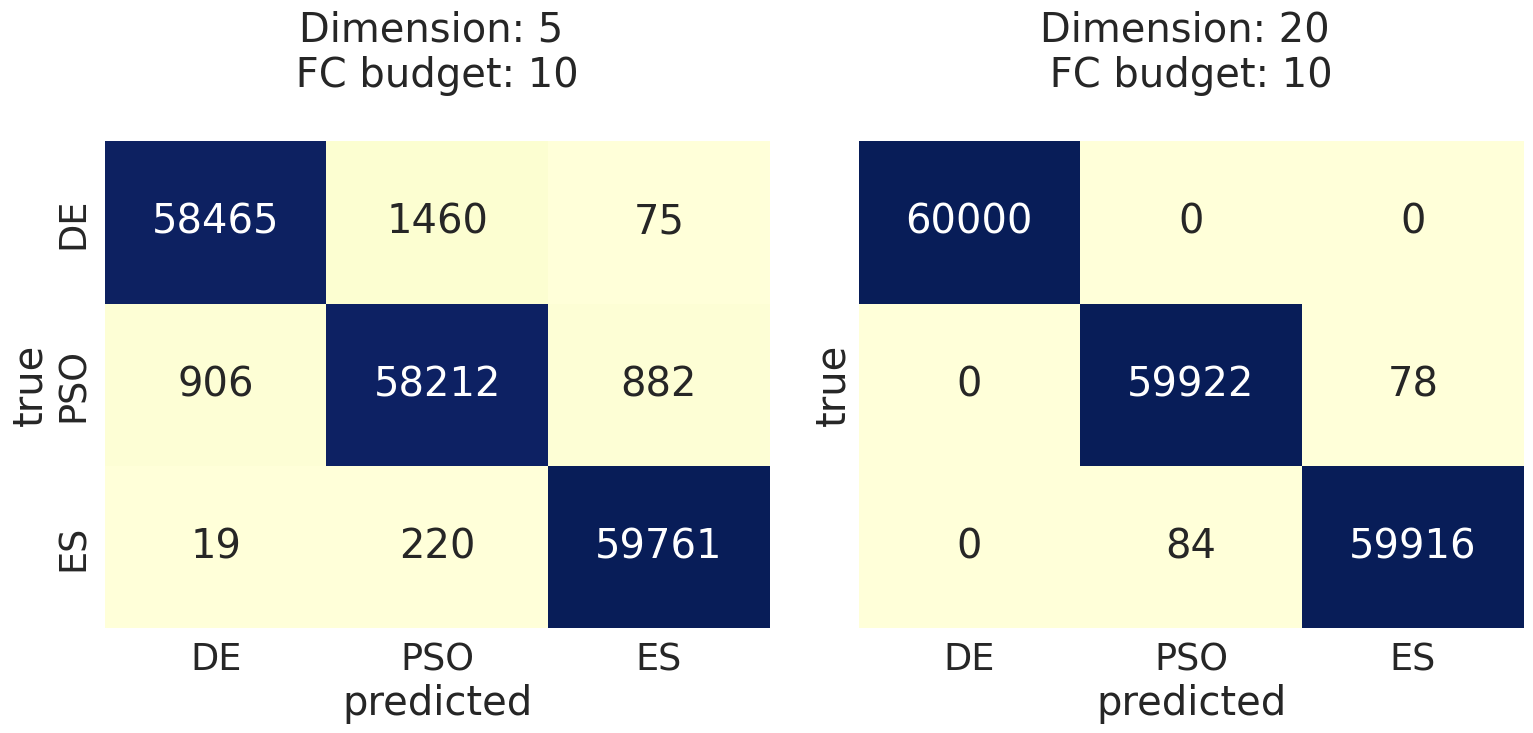

In [226]:
results_per_iteration=[]
all_algorithms='DE_PSO_ES'
all_dimensions=[5,20]
difference=True
train_on_seed=True
end_iterations=[9]

sns.set(font_scale=2.4)
fig, axes = plt.subplots(len(end_iterations),len(all_dimensions), figsize=( len(all_dimensions)*8,len(end_iterations)*8), squeeze=False, sharex=True, sharey=True)
for dimension_index, dimension in enumerate(all_dimensions):

    for end_iteration_index, end_iteration in enumerate(end_iterations):
        for normalize_y_index, normalize_y in enumerate([True]):
            _,predictions = get_seed_accuracies_df(dimension,all_algorithms, 0, end_iteration, train_on_seed, difference, seeds, normalize_y=normalize_y)
            ax=axes[end_iteration_index][dimension_index]
            ax.set_title(f'Dimension: {dimension} \n FC budget: {end_iteration + 1} \n')
            #d=ConfusionMatrixDisplay.from_predictions(predictions['y'],predictions['preds'],cmap=my_cmap, colorbar=True,ax=ax)
            
            c=confusion_matrix(predictions['y'],predictions['preds'], labels=all_algorithms.split('_'))
            sns.heatmap(pd.DataFrame(c, index=all_algorithms.split('_'), columns=all_algorithms.split('_')),cmap='YlGnBu', ax=ax, annot=True, cbar=False, fmt='.0f')
            ax.set_xlabel("predicted")
            ax.set_ylabel("true") 
rows=[f'Dimension: {d}' for d in all_dimensions]      
#for ax, row in zip(axes[:,0], rows):
#    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),xycoords=ax.yaxis.label, textcoords='offset points',size='large', ha='right', va='center', rotation= 90)
    
#plt.xticks(rotation=90)

plt.tight_layout()
plt.savefig(os.path.join(visualizations_dir,f'confusion_matrices_per_iteration_{"train" if train_on_seed else "test"}_on_seed{"_differenced" if difference else ""}_dim_{"-".join([str(d) for d in all_dimensions])}.pdf'))
plt.show()

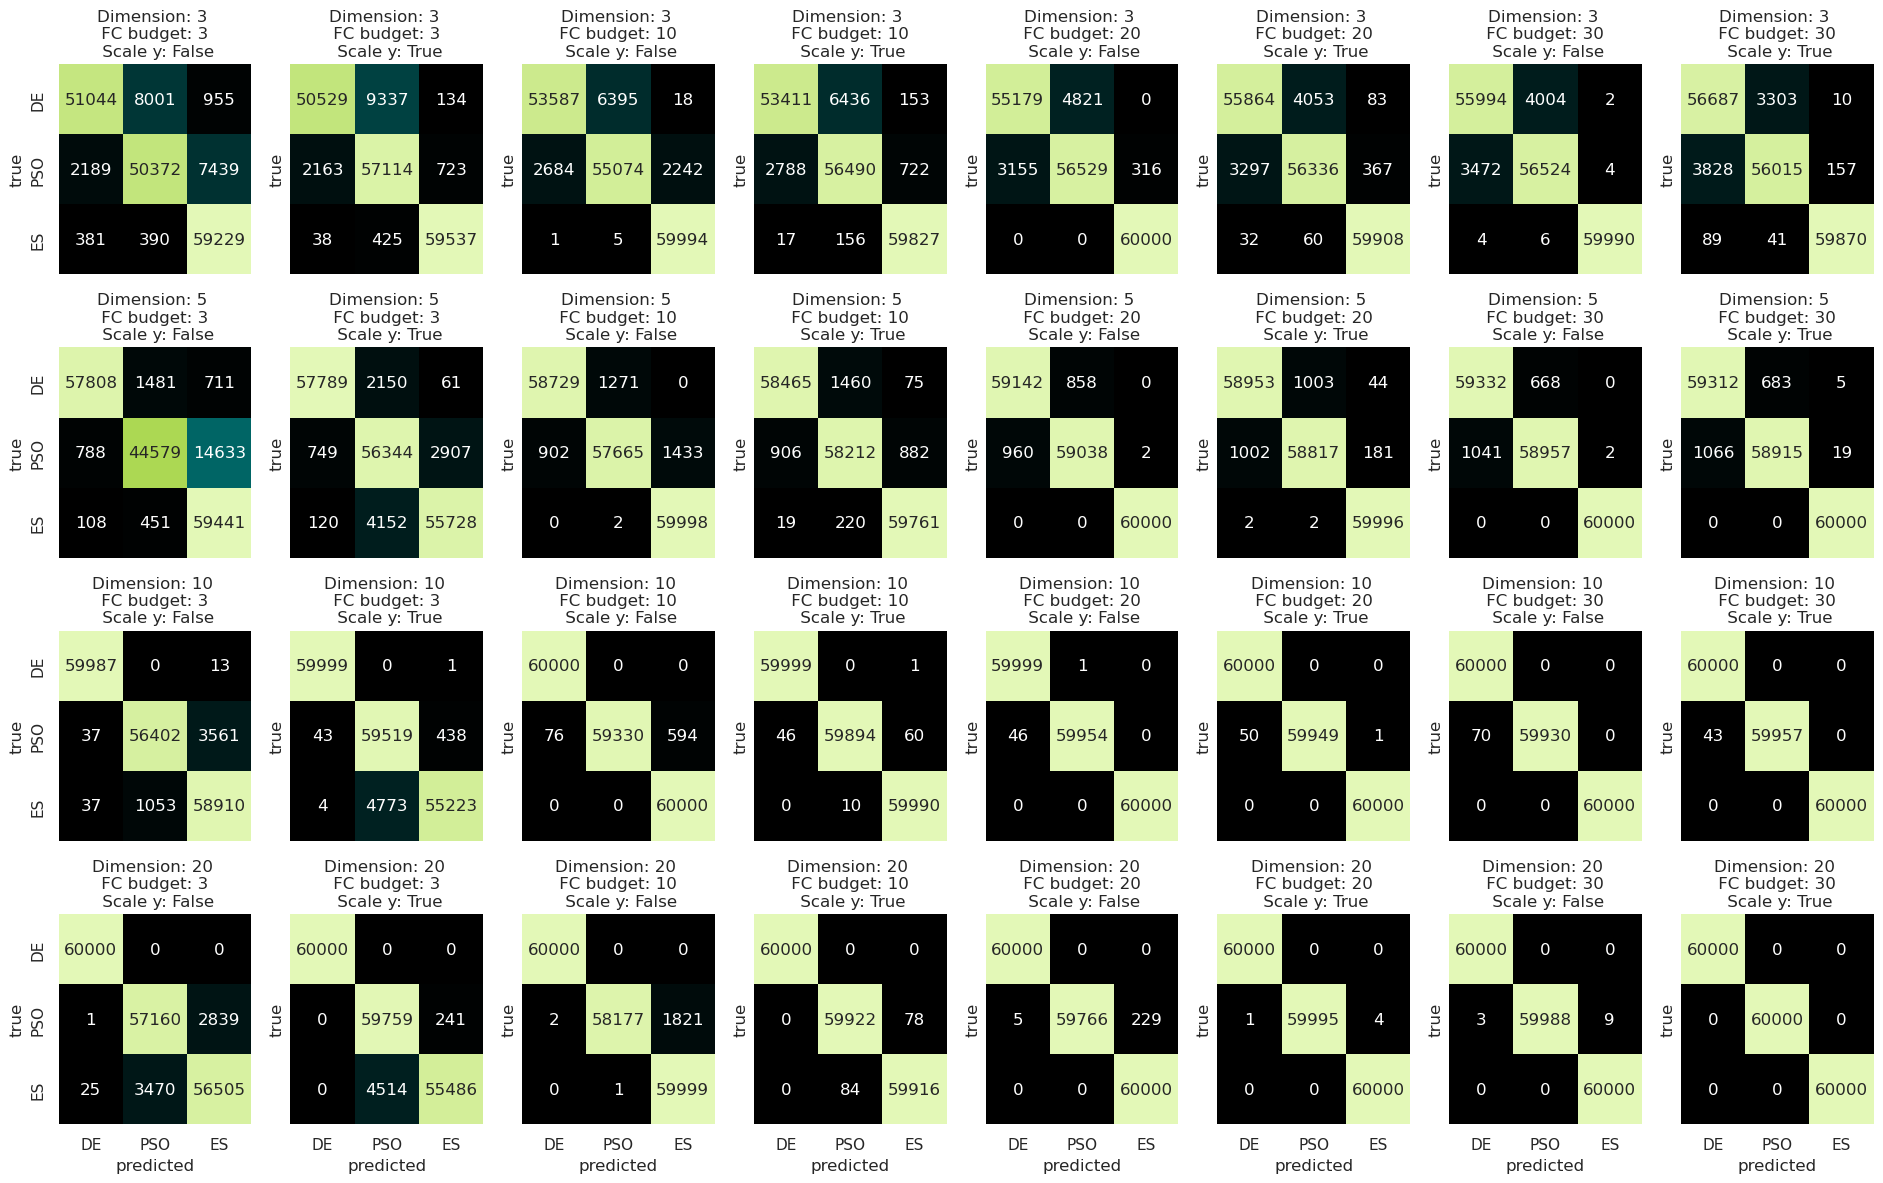

In [178]:
results_per_iteration=[]
all_algorithms='DE_PSO_ES'
all_dimensions=[3,5,10,20]
difference=True
train_on_seed=True
end_iterations=[2,9,19,29]

sns.set(font_scale=1)
fig, axes = plt.subplots(len(all_dimensions),len(end_iterations)*2, figsize=(19,12), squeeze=False, sharex=True, sharey=True)
for dimension_index, dimension in enumerate(all_dimensions):

    for end_iteration_index, end_iteration in enumerate(end_iterations):
        for normalize_y_index, normalize_y in enumerate([False,True]):
            _,predictions = get_seed_accuracies_df(dimension,all_algorithms, 0, end_iteration, train_on_seed, difference, seeds, normalize_y=normalize_y)
            ax=axes[dimension_index][end_iteration_index*2 + normalize_y_index]
            ax.set_title(f'Dimension: {dimension} \n FC budget: {end_iteration + 1} \n Scale y: {normalize_y}')
            #d=ConfusionMatrixDisplay.from_predictions(predictions['y'],predictions['preds'],cmap=my_cmap, colorbar=True,ax=ax)
            
            c=confusion_matrix(predictions['y'],predictions['preds'], labels=all_algorithms.split('_'))
            sns.heatmap(pd.DataFrame(c, index=all_algorithms.split('_'), columns=all_algorithms.split('_')),cmap='YlGnBu', ax=ax, annot=True, cbar=False, fmt='.0f')
            if dimension_index==3:
                ax.set_xlabel("predicted")
            ax.set_ylabel("true") 
rows=[f'Dimension: {d}' for d in all_dimensions]      
#for ax, row in zip(axes[:,0], rows):
#    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),xycoords=ax.yaxis.label, textcoords='offset points',size='large', ha='right', va='center', rotation= 90)
    
#plt.xticks(rotation=90)

plt.tight_layout()
plt.savefig(os.path.join(visualizations_dir,f'confusion_matrices_per_iteration_{"train" if train_on_seed else "test"}_on_seed{"_differenced" if difference else ""}.pdf'))
plt.show()

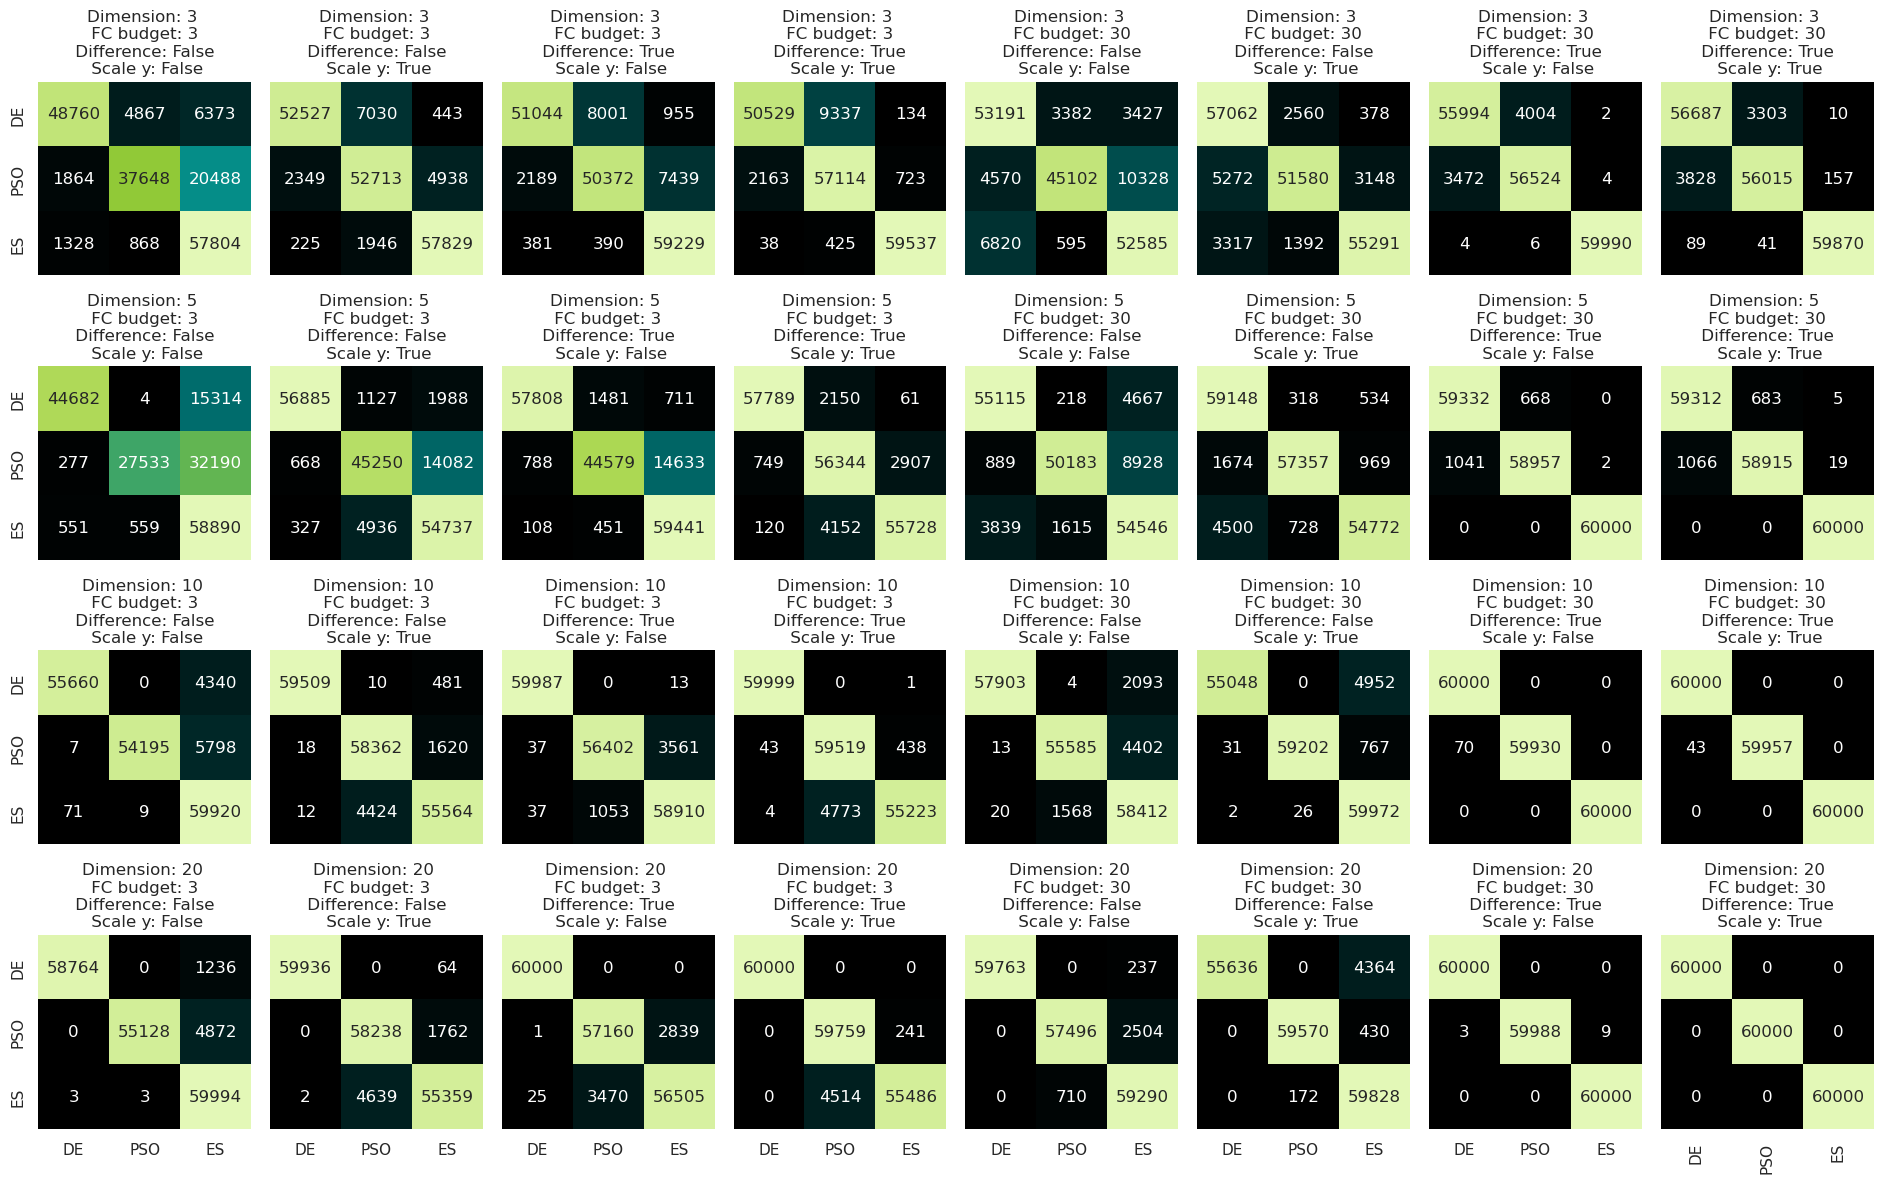

In [142]:
results_per_iteration=[]
all_algorithms='DE_PSO_ES'
all_dimensions=[3,5,10,20]

train_on_seed=True
end_iterations=[2,29]

sns.set(font_scale=1)
fig, axes = plt.subplots(len(all_dimensions),len(end_iterations)*4, figsize=(19,12), squeeze=False, sharex=True, sharey=True)
for dimension_index, dimension in enumerate(all_dimensions):

    for end_iteration_index, end_iteration in enumerate(end_iterations):
        for difference_index,difference in enumerate([False,True]):
            for normalize_y_index, normalize_y in enumerate([False,True]):
                _,predictions = get_seed_accuracies_df(dimension,all_algorithms, 0, end_iteration, train_on_seed, difference, seeds, normalize_y=normalize_y)
                ax=axes[dimension_index][end_iteration_index*4 + difference_index*2+ normalize_y_index]
                ax.set_title(f'Dimension: {dimension} \n FC budget: {end_iteration + 1} \n Difference: {difference} \n Scale y: {normalize_y}')
                #d=ConfusionMatrixDisplay.from_predictions(predictions['y'],predictions['preds'],cmap=my_cmap, colorbar=True,ax=ax)

                c=confusion_matrix(predictions['y'],predictions['preds'], labels=all_algorithms.split('_'))
                sns.heatmap(pd.DataFrame(c, index=all_algorithms.split('_'), columns=all_algorithms.split('_')),cmap=my_cmap, ax=ax, annot=True, cbar=False, fmt='.0f')
                
rows=[f'Dimension: {d}' for d in all_dimensions]      
#for ax, row in zip(axes[:,0], rows):
#    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),xycoords=ax.yaxis.label, textcoords='offset points',size='large', ha='right', va='center', rotation= 90)
    
plt.xticks(rotation=90)

plt.tight_layout()
plt.savefig(os.path.join(visualizations_dir,f'confusion_matrices_per_iteration_{"train" if train_on_seed else "test"}_on_seed_both_differenced_and_not_differenced.pdf'))
plt.show()

In [9]:
results_per_iteration=[]
all_algorithms='DE_PSO_ES'
all_dimensions=[3,5,10,20]
all_accuracies=pd.DataFrame()

train_on_seed=True
for difference in [False, True]:
    for dimension in all_dimensions:
        for normalize_y in [False,True]:

            for end_iteration in [2,4,9,19,29]:
                seed_accuracy_df,_ = get_seed_accuracies_df(dimension,all_algorithms, 0, end_iteration, train_on_seed, difference, seeds, normalize_y=normalize_y)
                if seed_accuracy_df is None or seed_accuracy_df.shape[0]==0:
                    print('EMPTY', dimension, end_iteration, train_on_seed, difference, normalize_y)
                    continue
                seed_accuracy_df['feature calculation budget']=end_iteration+1
                seed_accuracy_df['dimension']=dimension
                seed_accuracy_df['difference']=difference
                seed_accuracy_df['normalize_y']=normalize_y
                all_accuracies=pd.concat([all_accuracies,seed_accuracy_df])


all_accuracies['Train seed==Test seed']=all_accuracies.apply(lambda row: row['train_seed']==row['test_seed'] if train_on_seed else row['train_seed']!=row['test_seed'] , axis=1)
#accuracy_subplots(all_accuracies,all_dimensions,'dimension',f'accuracy_by_dimension_{"train" if train_on_seed else "test"}_on_seed{"_differenced" if difference else ""}.pdf')

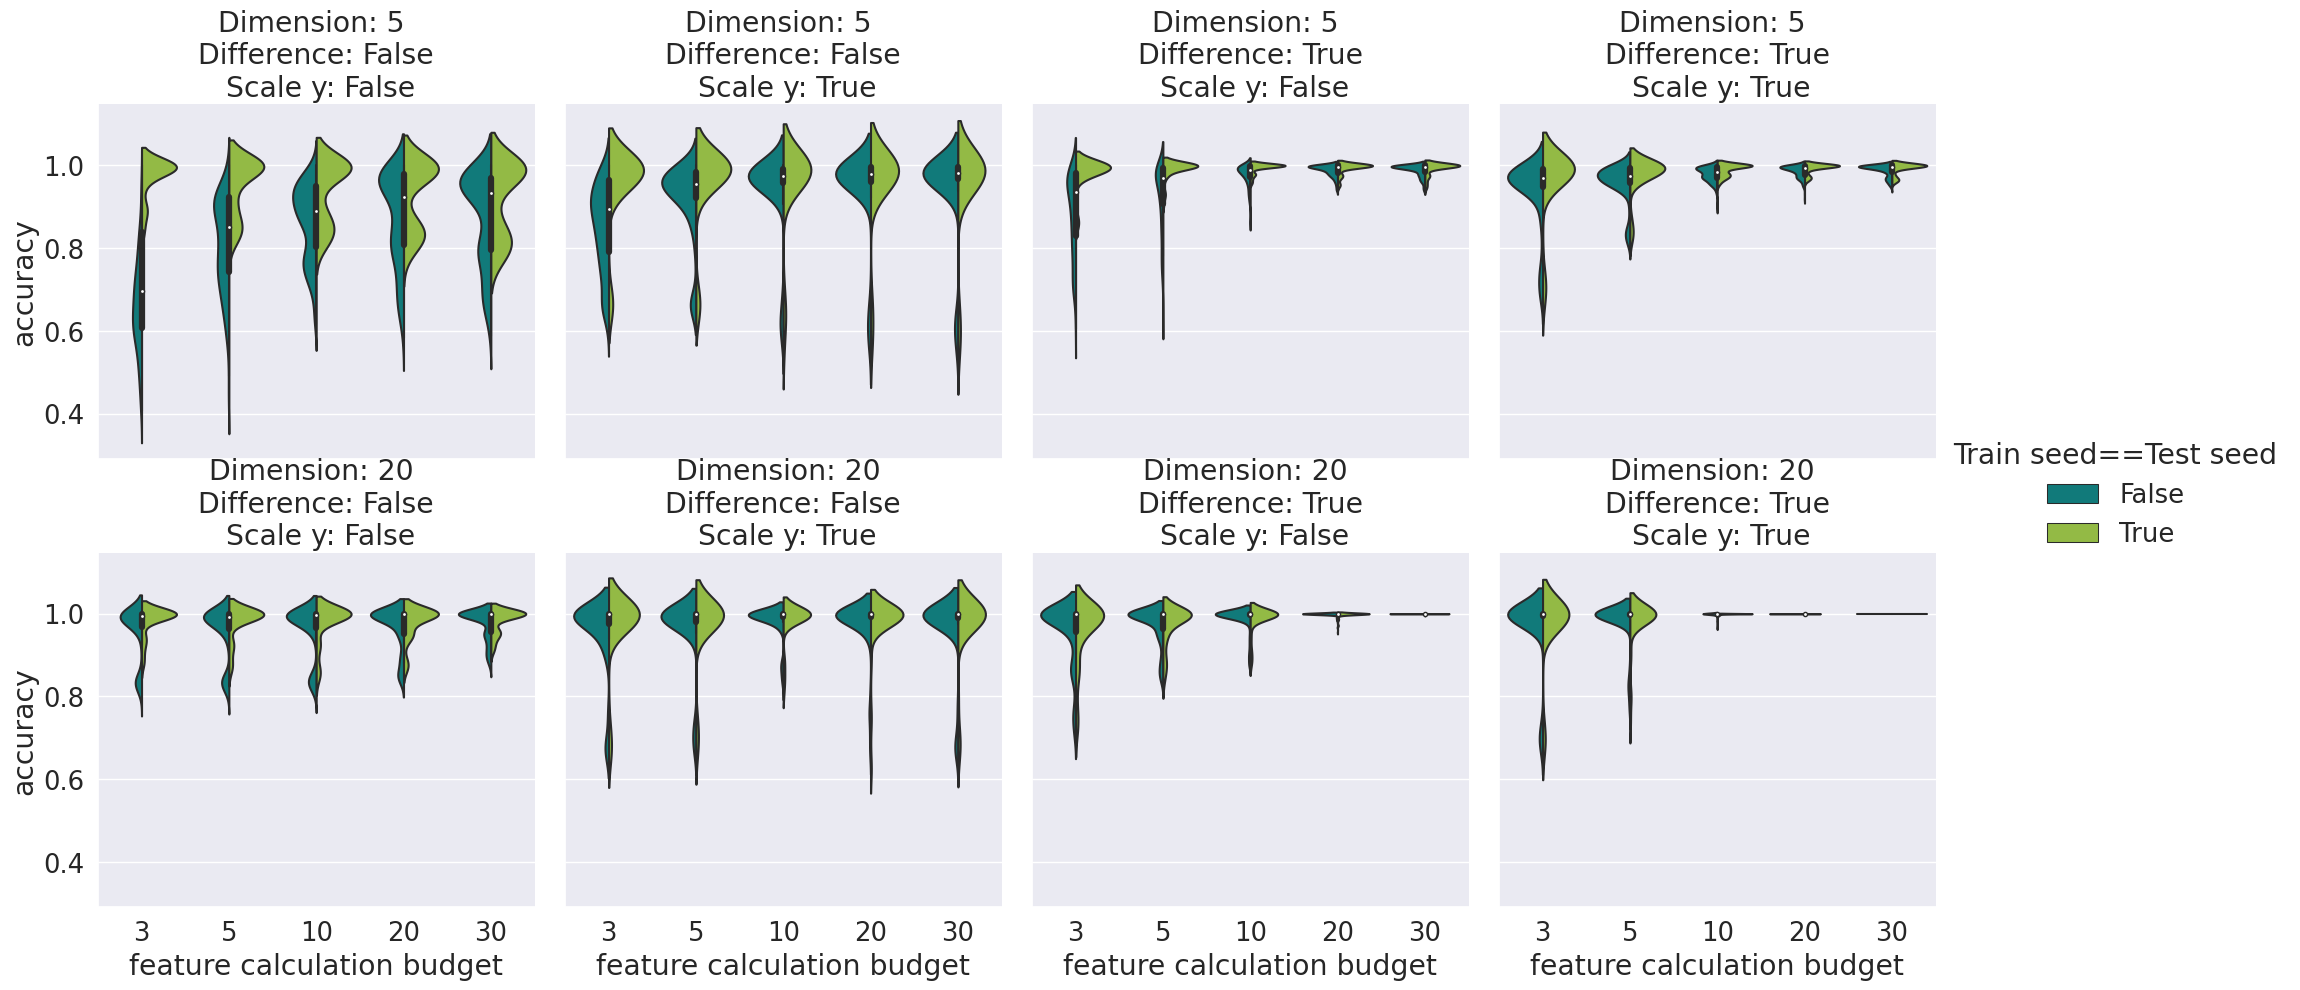

In [11]:


sns.set(font_scale=1.7)
all_accuracies['column'] = all_accuracies.apply(lambda row: f'Difference: {row["difference"]} \n Scale y: {row["normalize_y"]}', axis=1)
g=sns.catplot(
    data=all_accuracies.query('dimension==5 or dimension==20'), x='feature calculation budget', y='accuracy',
    col='column', row='dimension', kind='violin', palette=color_palette[1:3], hue='Train seed==Test seed', split=True
)
g.set_titles(row_template = 'Dimension: {row_name}', col_template = '{col_name}', template='Dimension: {row_name} \n {col_name}')


#plt.tight_layout()
plt.savefig(os.path.join(visualizations_dir,'all_dimensions_all_iterations_dim_5_20.pdf'))
plt.show()


In [21]:
all_accuracies_file=os.path.join(visualizations_dir,'all_accuracies.csv')
if not os.path.isfile(all_accuracies_file):
    print('recalculating accuracies')
    all_algorithms='DE_PSO_ES'
    all_dimensions=[3,5,10]

    all_accuracies=pd.DataFrame()
    for train_on_seed in [True]:
        for difference in [False, True]:
            for dimension in all_dimensions:

                for end_iteration in [2,9,19,29,39,49]:
                    for normalize_y in [True,False]:
                        seed_accuracy_df,_ = get_seed_accuracies_df(dimension,all_algorithms, 0, end_iteration, train_on_seed, difference, seeds, normalize_y=normalize_y)
                        seed_accuracy_df['feature calculation budget']=end_iteration+1
                        seed_accuracy_df['dimension']=dimension
                        seed_accuracy_df['difference']=difference
                        seed_accuracy_df['train_on_seed']=train_on_seed
                        seed_accuracy_df['normalize_y']=normalize_y
                        seed_accuracy_df['Train seed==Test seed']=seed_accuracy_df.apply(lambda row: row['train_seed']==row['test_seed'] if train_on_seed else row['train_seed']!=row['test_seed'] , axis=1)

                        all_accuracies=pd.concat([all_accuracies,seed_accuracy_df])


    
    all_accuracies.to_csv(os.path.join(visualizations_dir,'all_accuracies.csv'))

else:
    all_accuracies=pd.read_csv(all_accuracies_file, index_col=0)


recalculating accuracies


In [ ]:
axes_row=-1
fig, axes = plt.subplots(4,4, figsize=(12,12), sharex=True, sharey=True, squeeze=False)
for train_on_seed in [True,False]:
    for difference in [False, True]:
        axes_row+=1
        
        setting_accuracies=all_accuracies.query('train_on_seed==@train_on_seed and difference==@difference')

        for dimension_index, dimension in enumerate(all_dimensions):
            dimension_accuracies=setting_accuracies.query('dimension==@dimension')
            ax=axes[axes_row, dimension_index] if type(axes) is np.ndarray else axes
            ax.set_title(f'Dimension: {dimension}')
            sns.violinplot(data=dimension_accuracies, x="feature calculation budget", y="accuracy", hue='Same seed results', split=True, palette=color_palette[1:3], ax=ax)
            if dimension_index != 0 or axes_row!=0:
                ax.get_legend().remove()
                
rows=['Experimental setting 1,\n original features', 'Experimental setting 1,\n differenced features','Experimental setting 2,\n original features','Experimental setting 2,\n differenced features']      
for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', rotation= 90)
                
plt.tight_layout()

plt.savefig(os.path.join(visualizations_dir,'all_dimensions_all_iterations.pdf'))
plt.show()

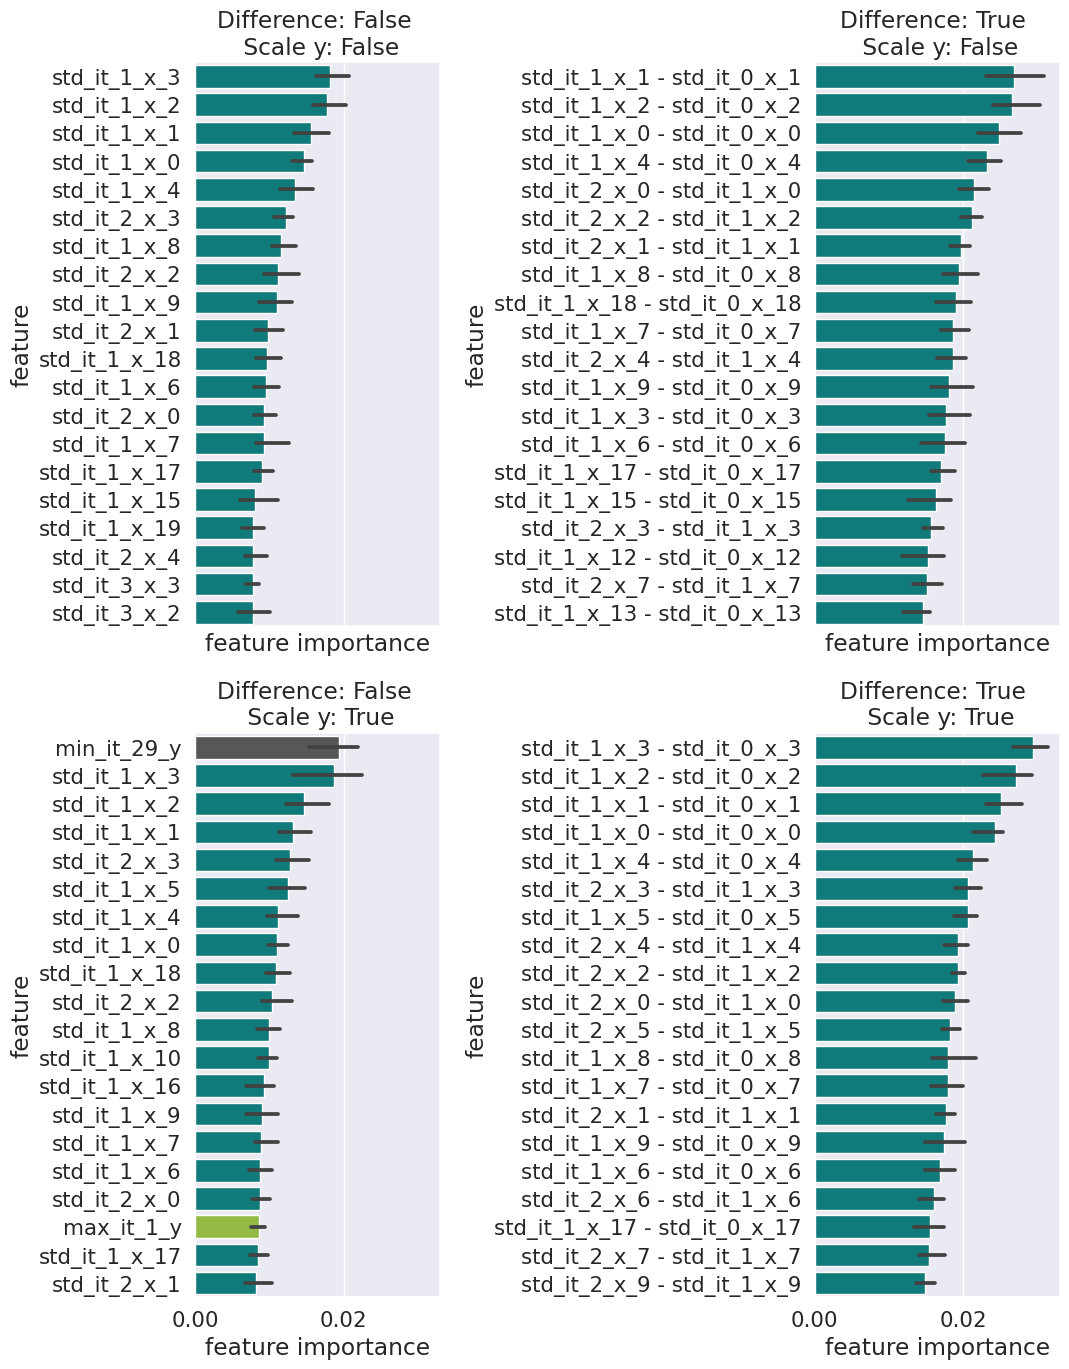

In [158]:
sns.set(font_scale=1.4)
fig, axes = plt.subplots(2,2, figsize=(11,14), sharex=True)
end_iteration=29

for difference_index, difference in enumerate([False,True]):
    for normalize_index, normalize_y in enumerate([False,True]):    
        all_feature_importances_df=pd.DataFrame()
        for dimension_index,dimension in enumerate([3,5,10,20]):      
            for seed in seeds:
                for fold in range(0,10):
                    global_file_name=get_global_file_name(dimension,all_algorithms, 0, end_iteration,True, seed, difference, normalize_y=normalize_y)
                    file_location=global_file_name+f'_fold_{fold}_feature_importance.csv'

                    if not os.path.isfile(file_location):
                        print('Not found', file_location)
                        continue
                    #print(file_location)
                    fold_importance_df=pd.read_csv(file_location, index_col=[0], compression='zip')
                    fold_importance_df['seed']=seed
                    fold_importance_df['fold']=fold
                    fold_importance_df['budget']=end_iteration+1
                    fold_importance_df['difference']=difference
                    fold_importance_df['normalize_y']=normalize_y
                    all_feature_importances_df=pd.concat([all_feature_importances_df, fold_importance_df])

        all_feature_importances_df.columns=[c.replace('_dim_','_x_') if f'_dim_{dimension}' not in c else c.replace(f'_dim_{dimension}','_y') for c in all_feature_importances_df.columns]

        ax=axes[ normalize_index,difference_index] if type(axes) is np.ndarray else axes
        ax.set_title(f'Difference: {difference} \n Scale y: {normalize_y}')

        id_vars=['seed','fold','budget','difference','normalize_y']

        top_features=all_feature_importances_df.drop(columns=id_vars).median().sort_values(ascending=False).head(20)

        top_features=list(top_features.index)


        all_feature_importances_df_melted=pd.melt(all_feature_importances_df[top_features+id_vars], id_vars=id_vars, value_vars=top_features)
        all_feature_importances_df_melted['statistic']=all_feature_importances_df_melted['variable'].apply(lambda x: x.split('_')[0])
        sns.barplot(all_feature_importances_df_melted, y='variable',x='value',hue='statistic',estimator='median',palette=[light_blue,dark_cyan,lime, grey], ax=ax,dodge=False, hue_order=['mean','std','max','min'])
        ax.set_xlabel('feature importance')
        ax.set_ylabel('feature')


        if dimension_index==0 and normalize_index==1 and difference_index==1:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        else: 
            ax.get_legend().remove()
plt.tight_layout()

plt.savefig(os.path.join(visualizations_dir,'feature_importance_across_dimensions.pdf'))
plt.show()

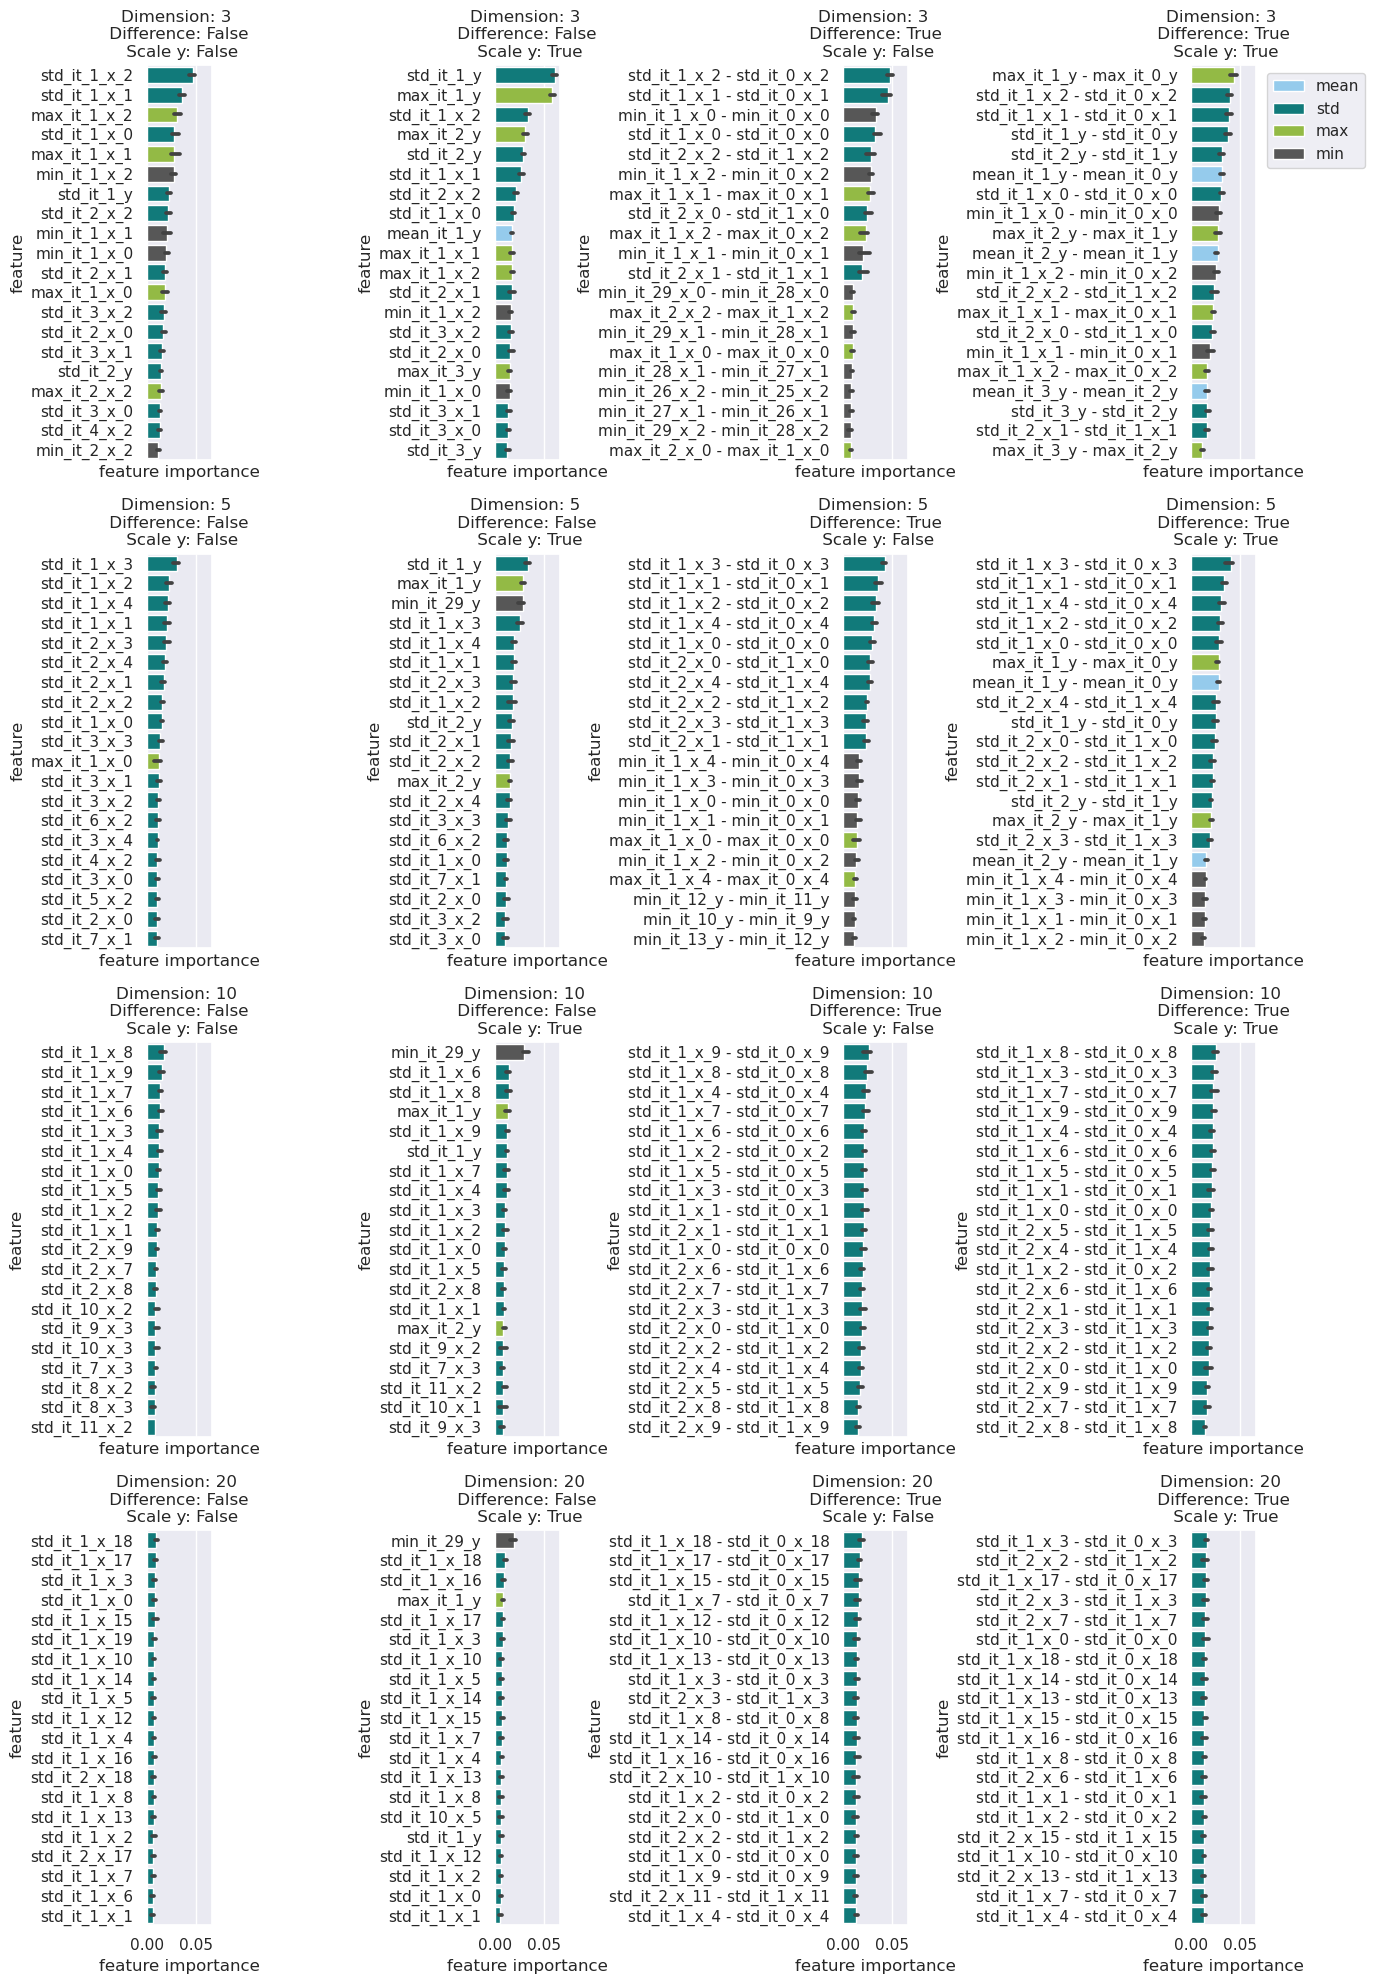

In [86]:
fig, axes = plt.subplots(4,4, figsize=(14,20), sharex=True)
end_iteration=29
for dimension_index,dimension in enumerate([3,5,10,20]):
    for difference_index, difference in enumerate([False,True]):
        for normalize_index, normalize_y in enumerate([False,True]):
            all_feature_importances_df=pd.DataFrame()
            for seed in seeds:

                for fold in range(0,10):
                    global_file_name=get_global_file_name(dimension,all_algorithms, 0, end_iteration,True, seed, difference, normalize_y=normalize_y)
                    file_location=global_file_name+f'_fold_{fold}_feature_importance.csv'

                    if not os.path.isfile(file_location):
                        print('Not found', file_location)
                        continue
                    #print(file_location)
                    fold_importance_df=pd.read_csv(file_location, index_col=[0], compression='zip')
                    fold_importance_df['seed']=seed
                    fold_importance_df['fold']=fold
                    fold_importance_df['budget']=end_iteration+1
                    fold_importance_df['difference']=difference
                    fold_importance_df['normalize_y']=normalize_y
                    all_feature_importances_df=pd.concat([all_feature_importances_df, fold_importance_df])

            all_feature_importances_df.columns=[c.replace('_dim_','_x_') if f'_dim_{dimension}' not in c else c.replace(f'_dim_{dimension}','_y') for c in all_feature_importances_df.columns]

            ax=axes[dimension_index, difference_index*2 + normalize_index] if type(axes) is np.ndarray else axes
            ax.set_title(f'Dimension: {dimension} \n Difference: {difference} \n Scale y: {normalize_y}')

            id_vars=['seed','fold','budget','difference','normalize_y']

            top_features=all_feature_importances_df.drop(columns=id_vars).median().sort_values(ascending=False).head(20)

            top_features=list(top_features.index)


            all_feature_importances_df_melted=pd.melt(all_feature_importances_df[top_features+id_vars], id_vars=id_vars, value_vars=top_features)
            all_feature_importances_df_melted['statistic']=all_feature_importances_df_melted['variable'].apply(lambda x: x.split('_')[0])
            sns.barplot(all_feature_importances_df_melted, y='variable',x='value',hue='statistic',estimator='median',palette=[light_blue,dark_cyan,lime, grey], ax=ax,dodge=False, hue_order=['mean','std','max','min'])
            ax.set_xlabel('feature importance')
            ax.set_ylabel('feature')
            
            
            if dimension_index==0 and normalize_index==1 and difference_index==1:
                ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            else: 
                ax.get_legend().remove()
plt.tight_layout()

plt.savefig(os.path.join(visualizations_dir,'feature_importance_per_dimension.pdf'))
plt.show()

In [ ]:
id_vars=['algorithm','seed','fold']
top_30_features=list(all_feature_importances_df.drop(columns=id_vars).median().sort_values(ascending=False).head(30).index)


all_feature_importances_df_melted=pd.melt(all_feature_importances_df[top_30_features+id_vars], id_vars=id_vars, value_vars=top_30_features)
plt.figure(figsize=(6,9))

sns.barplot(all_feature_importances_df_melted, y='variable',x='value',palette=color_palette)
plt.tight_layout()
plt.savefig(os.path.join(visualizations_dir,'top_30_feature_importance.pdf'))